In [1]:
import torch
import torch.nn as nn
import torchvision as tv
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam, SGD
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import pendulum
from tqdm import tqdm

# Model

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.losses = {}
        self.accuracys = {}
        self.iterations = 0
        
        self.l1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.l2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=10)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.l2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        
        return out
    
    def fit(self, optimizer, error, train_loader):
        for images, labels in tqdm(train_loader):
            self.iterations += 1

            images, labels = images.to(device), labels.to(device)
            train = Variable(images.view(*images.shape))
            #train = Variable(images)
            labels = Variable(labels)

            outputs = self.forward(train)
            loss = error(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            self.loss = loss
            self.losses[self.iterations] = loss.data

    
    def validate(self, val_loader):
        test_list = []
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            val = Variable(images.view(*images.shape))
            outputs = self.forward(val)
        
            predictions = torch.max(outputs, 1)[1].to(device)

            test_list.append({
                'y_pred': predictions,
                'y_true': labels,
                'correct': (predictions == labels).sum(),
                'length': len(labels)
            })
        
        correct = sum([t['correct'] for t in test_list])
        total = sum([t['length'] for t in test_list])
        accuracy = correct * 100 / total

        self.accuracys[self.iterations] = accuracy

        return accuracy, test_list

# Functions

In [3]:
class_name = lambda cls: str(cls).split("<class '")[1].split("'>")[0].split(".")[-1]


def load_data(batch_size=100, train_size=50000, val_size=10000):
    dataset = tv.datasets.FashionMNIST(
        root='./data',
        train=True,
        transform=tv.transforms.ToTensor(),
        download=True
    )

    test_set = tv.datasets.FashionMNIST(
        root = './data',
        train = False,
        transform = tv.transforms.ToTensor(),
        download = True
    )

    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

    # Data loader
    train_loader = torch.utils.data.DataLoader(
        dataset=train_set, 
        batch_size=batch_size, 
        shuffle=True
    )

    val_loader = torch.utils.data.DataLoader(
        dataset=val_set,
        batch_size=batch_size,
        shuffle=True
    )

    test_loader = torch.utils.data.DataLoader(
        dataset=test_set, 
        batch_size=batch_size, 
        shuffle=False
    )

    return {
        'train': train_loader,
        'val': val_loader,
        'test': test_loader,
        'dataset': dataset
    }


def image_dataset_merge(rows, cols, dataset):
    subset = torch.utils.data.Subset(dataset, np.arange(rows*cols))

    row_images = []
    for i in range(rows):
        row = torch.utils.data.Subset(subset, np.arange(i*cols, (i*cols) + cols))
        images = [a[0][0].numpy() for a in row]
        row_images.append(np.concatenate(images, axis=1))

    tot_image = np.concatenate(row_images)

    return tot_image


def filter_dataset(dataset, func):
    target_indices = np.arange(len(dataset.targets))
    mask = func(dataset.targets).numpy()
    mask_idx = target_indices[mask]
    subset = torch.utils.data.Subset(dataset, mask_idx)
    return subset


def train_and_save(train_loader, val_loader, load_model=False, model_path='./data/model.pth', opt=Adam, er=nn.CrossEntropyLoss, learning_rate=0.001, num_epochs=10):
    if load_model:
        model = torch.load(model_path)
    else:
        model = CNN()

    model.to(device)

    optimizer=opt(model.parameters(), lr=learning_rate)
    error = er()

    for i in range(num_epochs):
        model.fit(optimizer, error, train_loader)
        model.validate(val_loader)
        print(f"Epoch[{i+1}/{num_epochs}]: Iteration: {model.iterations}, Loss: {model.losses[model.iterations]}, Accuracy: {model.accuracys[model.iterations]}")


    torch.save(model, model_path)

    losses = model.losses.copy()
    losses = [(k, v) for k, v in losses.items() if k in [a for a in model.accuracys]]
    sorted_losses = sorted(losses, key=lambda x: x[1])

    best = {
        'optimizer': class_name(opt),
        'error': class_name(er),
        'loss': sorted_losses[0][1],
        'iteration': sorted_losses[0][0],
        'accuracy': model.accuracys[sorted_losses[0][0]],
        'learning_rate': learning_rate
    }
    return model, best

# Checking if gpu is available

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Data loading

In [5]:
# Fashion MNIST dataset 
batch_size=100
train_size=50000
val_size=10000

data_dict = load_data(batch_size=batch_size, train_size=train_size, val_size=val_size)
train_loader = data_dict['train']
val_loader = data_dict['val']
test_loader = data_dict['test']
dataset = data_dict['dataset']
print(dataset)
print(f'The dataset FashionMNIST have 60000 datapoints.')

Dataset FashionMNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None
The dataset FashionMNIST have 60000 datapoints.


### Visualizing dataset grouped by class

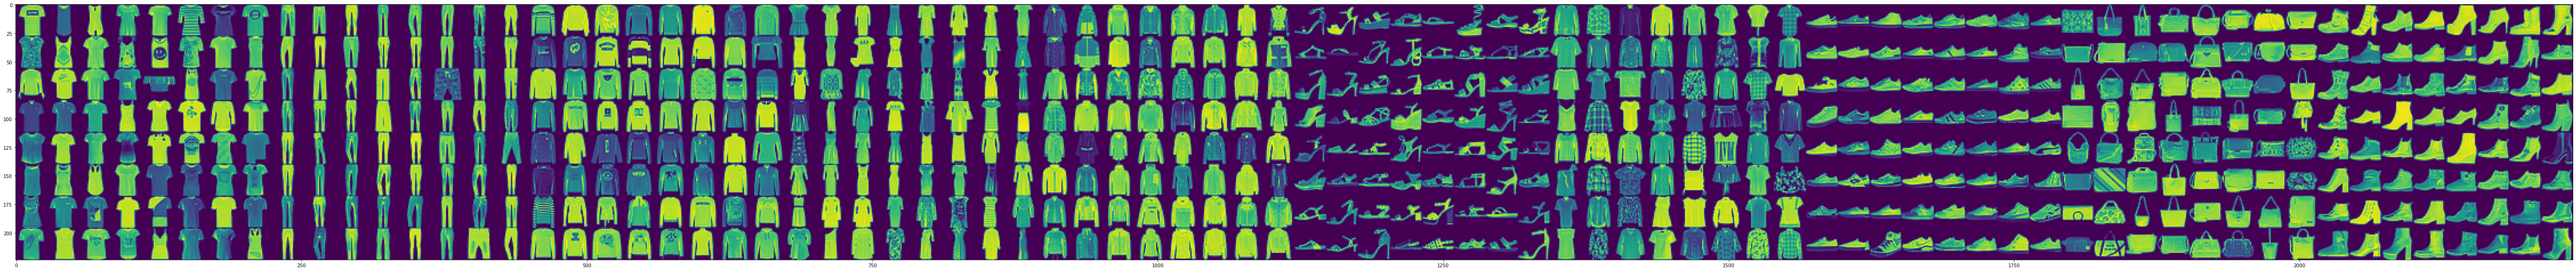

In [6]:
label_map = {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat", 
    5: "Sandal", 
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}

images = []
for label in range(10):
    subset = filter_dataset(dataset, lambda target: target == label)
    img = image_dataset_merge(8, 8, subset)
    images.append(img)

plt.figure(figsize=(100, 10))
plt.imshow(np.concatenate(images, axis=1))
plt.show()

# Optimizers

In [7]:
#Init list for best losses for each configuration.
best_losses = []

## Adam

In [8]:
learning_rates = [0.0001, 0.001, 0.01]
for lr in learning_rates:
    print(f'Training Model with Adam Optimizer of learning rate: {lr}')
    model, best = train_and_save(train_loader, val_loader, opt=Adam, load_model=False, num_epochs=10, learning_rate=lr)
    best_losses.append(best)
    print('-' * 120)

Training Model with Adam Optimizer of learning rate: 0.0001


100%|██████████| 100/100 [00:00<00:00, 143.27it/s]


Epoch[1/10]: Iteration: 500, Loss: 0.344666451215744, Accuracy: 87.37999725341797


100%|██████████| 100/100 [00:00<00:00, 141.26it/s]


Epoch[2/10]: Iteration: 1000, Loss: 0.2079576700925827, Accuracy: 89.0199966430664


100%|██████████| 100/100 [00:00<00:00, 151.75it/s]


Epoch[3/10]: Iteration: 1500, Loss: 0.2674770653247833, Accuracy: 89.6199951171875


100%|██████████| 100/100 [00:00<00:00, 147.52it/s]


Epoch[4/10]: Iteration: 2000, Loss: 0.3518555462360382, Accuracy: 89.48999786376953


100%|██████████| 100/100 [00:00<00:00, 145.23it/s]


Epoch[5/10]: Iteration: 2500, Loss: 0.1644502580165863, Accuracy: 90.58999633789062


100%|██████████| 100/100 [00:00<00:00, 146.89it/s]


Epoch[6/10]: Iteration: 3000, Loss: 0.22803710401058197, Accuracy: 90.62999725341797


100%|██████████| 100/100 [00:00<00:00, 147.23it/s]


Epoch[7/10]: Iteration: 3500, Loss: 0.1280280500650406, Accuracy: 91.16999816894531


100%|██████████| 100/100 [00:00<00:00, 150.58it/s]


Epoch[8/10]: Iteration: 4000, Loss: 0.14182788133621216, Accuracy: 90.66999816894531


100%|██████████| 100/100 [00:00<00:00, 151.36it/s]


Epoch[9/10]: Iteration: 4500, Loss: 0.12228106707334518, Accuracy: 90.93999481201172


100%|██████████| 100/100 [00:00<00:00, 153.02it/s]


Epoch[10/10]: Iteration: 5000, Loss: 0.19262675940990448, Accuracy: 91.19999694824219
------------------------------------------------------------------------------------------------------------------------
Training Model with Adam Optimizer of learning rate: 0.001


100%|██████████| 100/100 [00:00<00:00, 143.41it/s]


Epoch[1/10]: Iteration: 500, Loss: 0.276775985956192, Accuracy: 87.0199966430664


100%|██████████| 100/100 [00:00<00:00, 138.60it/s]


Epoch[2/10]: Iteration: 1000, Loss: 0.31628504395484924, Accuracy: 89.69999694824219


100%|██████████| 100/100 [00:00<00:00, 150.66it/s]


Epoch[3/10]: Iteration: 1500, Loss: 0.1664654016494751, Accuracy: 89.93999481201172


100%|██████████| 100/100 [00:00<00:00, 145.57it/s]


Epoch[4/10]: Iteration: 2000, Loss: 0.16698917746543884, Accuracy: 88.73999786376953


100%|██████████| 100/100 [00:00<00:00, 144.94it/s]


Epoch[5/10]: Iteration: 2500, Loss: 0.27702000737190247, Accuracy: 90.12999725341797


100%|██████████| 100/100 [00:00<00:00, 148.31it/s]


Epoch[6/10]: Iteration: 3000, Loss: 0.19852378964424133, Accuracy: 90.27999877929688


100%|██████████| 100/100 [00:00<00:00, 150.01it/s]


Epoch[7/10]: Iteration: 3500, Loss: 0.06752229481935501, Accuracy: 90.06999969482422


100%|██████████| 100/100 [00:00<00:00, 143.12it/s]


Epoch[8/10]: Iteration: 4000, Loss: 0.13585300743579865, Accuracy: 91.41999816894531


100%|██████████| 100/100 [00:00<00:00, 146.68it/s]


Epoch[9/10]: Iteration: 4500, Loss: 0.14210915565490723, Accuracy: 90.5199966430664


100%|██████████| 100/100 [00:00<00:00, 152.02it/s]


Epoch[10/10]: Iteration: 5000, Loss: 0.12939968705177307, Accuracy: 91.72999572753906
------------------------------------------------------------------------------------------------------------------------
Training Model with Adam Optimizer of learning rate: 0.01


100%|██████████| 100/100 [00:00<00:00, 152.06it/s]


Epoch[1/10]: Iteration: 500, Loss: 0.3092842102050781, Accuracy: 85.8499984741211


100%|██████████| 100/100 [00:00<00:00, 152.31it/s]


Epoch[2/10]: Iteration: 1000, Loss: 0.34658607840538025, Accuracy: 87.73999786376953


100%|██████████| 100/100 [00:00<00:00, 149.11it/s]


Epoch[3/10]: Iteration: 1500, Loss: 0.3046822249889374, Accuracy: 89.9000015258789


100%|██████████| 100/100 [00:00<00:00, 150.03it/s]


Epoch[4/10]: Iteration: 2000, Loss: 0.3629508912563324, Accuracy: 89.4000015258789


100%|██████████| 100/100 [00:00<00:00, 147.15it/s]


Epoch[5/10]: Iteration: 2500, Loss: 0.27421653270721436, Accuracy: 89.29999542236328


100%|██████████| 100/100 [00:00<00:00, 144.69it/s]


Epoch[6/10]: Iteration: 3000, Loss: 0.17543481290340424, Accuracy: 89.79999542236328


100%|██████████| 100/100 [00:00<00:00, 151.56it/s]


Epoch[7/10]: Iteration: 3500, Loss: 0.11334742605686188, Accuracy: 88.83999633789062


100%|██████████| 100/100 [00:00<00:00, 146.72it/s]


Epoch[8/10]: Iteration: 4000, Loss: 0.38628682494163513, Accuracy: 88.68000030517578


100%|██████████| 100/100 [00:00<00:00, 147.09it/s]


Epoch[9/10]: Iteration: 4500, Loss: 0.1784954071044922, Accuracy: 89.97999572753906


100%|██████████| 100/100 [00:00<00:00, 148.27it/s]


Epoch[10/10]: Iteration: 5000, Loss: 0.2682782709598541, Accuracy: 89.75
------------------------------------------------------------------------------------------------------------------------


## SGD

In [9]:
learning_rates = [0.0001, 0.001, 0.01]
for lr in learning_rates:
    print(f'Training Model with SGD Optimizer of learning rate: {lr}')
    model, best = train_and_save(train_loader, val_loader, opt=SGD, load_model=False, num_epochs=10, learning_rate=lr)
    best_losses.append(best)
    print('-' * 120)

Training Model with SGD Optimizer of learning rate: 0.0001


100%|██████████| 100/100 [00:00<00:00, 152.64it/s]


Epoch[1/10]: Iteration: 500, Loss: 1.748282790184021, Accuracy: 52.72999954223633


100%|██████████| 100/100 [00:00<00:00, 148.90it/s]


Epoch[2/10]: Iteration: 1000, Loss: 1.428519606590271, Accuracy: 64.4000015258789


100%|██████████| 100/100 [00:00<00:00, 152.88it/s]


Epoch[3/10]: Iteration: 1500, Loss: 1.138969898223877, Accuracy: 69.29000091552734


100%|██████████| 100/100 [00:00<00:00, 144.39it/s]


Epoch[4/10]: Iteration: 2000, Loss: 1.0665019750595093, Accuracy: 71.91999816894531


100%|██████████| 100/100 [00:00<00:00, 151.71it/s]


Epoch[5/10]: Iteration: 2500, Loss: 0.9759296178817749, Accuracy: 73.16999816894531


100%|██████████| 100/100 [00:00<00:00, 141.92it/s]


Epoch[6/10]: Iteration: 3000, Loss: 0.9227008819580078, Accuracy: 73.97000122070312


100%|██████████| 100/100 [00:00<00:00, 140.74it/s]


Epoch[7/10]: Iteration: 3500, Loss: 0.8737375140190125, Accuracy: 74.33999633789062


100%|██████████| 100/100 [00:00<00:00, 137.03it/s]


Epoch[8/10]: Iteration: 4000, Loss: 0.7655980587005615, Accuracy: 75.33000183105469


100%|██████████| 100/100 [00:00<00:00, 145.03it/s]


Epoch[9/10]: Iteration: 4500, Loss: 0.66582190990448, Accuracy: 75.20999908447266


100%|██████████| 100/100 [00:00<00:00, 153.44it/s]


Epoch[10/10]: Iteration: 5000, Loss: 0.7629604935646057, Accuracy: 76.0199966430664
------------------------------------------------------------------------------------------------------------------------
Training Model with SGD Optimizer of learning rate: 0.001


100%|██████████| 100/100 [00:00<00:00, 143.97it/s]


Epoch[1/10]: Iteration: 500, Loss: 0.7895148992538452, Accuracy: 76.62999725341797


100%|██████████| 100/100 [00:00<00:00, 142.76it/s]


Epoch[2/10]: Iteration: 1000, Loss: 0.6272391080856323, Accuracy: 79.22999572753906


100%|██████████| 100/100 [00:00<00:00, 141.48it/s]


Epoch[3/10]: Iteration: 1500, Loss: 0.43557578325271606, Accuracy: 81.36000061035156


100%|██████████| 100/100 [00:00<00:00, 147.96it/s]


Epoch[4/10]: Iteration: 2000, Loss: 0.7890461683273315, Accuracy: 82.82999420166016


100%|██████████| 100/100 [00:00<00:00, 145.52it/s]


Epoch[5/10]: Iteration: 2500, Loss: 0.6119737029075623, Accuracy: 83.54000091552734


100%|██████████| 100/100 [00:00<00:00, 145.86it/s]


Epoch[6/10]: Iteration: 3000, Loss: 0.5661430954933167, Accuracy: 84.45999908447266


100%|██████████| 100/100 [00:00<00:00, 145.07it/s]


Epoch[7/10]: Iteration: 3500, Loss: 0.43862760066986084, Accuracy: 84.97999572753906


100%|██████████| 100/100 [00:00<00:00, 144.94it/s]


Epoch[8/10]: Iteration: 4000, Loss: 0.5202336311340332, Accuracy: 85.5


100%|██████████| 100/100 [00:00<00:00, 146.17it/s]


Epoch[9/10]: Iteration: 4500, Loss: 0.47756290435791016, Accuracy: 85.97000122070312


100%|██████████| 100/100 [00:00<00:00, 143.45it/s]


Epoch[10/10]: Iteration: 5000, Loss: 0.3163948953151703, Accuracy: 86.13999938964844
------------------------------------------------------------------------------------------------------------------------
Training Model with SGD Optimizer of learning rate: 0.01


100%|██████████| 100/100 [00:00<00:00, 145.04it/s]


Epoch[1/10]: Iteration: 500, Loss: 0.5147820115089417, Accuracy: 86.32999420166016


100%|██████████| 100/100 [00:00<00:00, 151.93it/s]


Epoch[2/10]: Iteration: 1000, Loss: 0.3904010057449341, Accuracy: 87.90999603271484


100%|██████████| 100/100 [00:00<00:00, 149.04it/s]


Epoch[3/10]: Iteration: 1500, Loss: 0.318243145942688, Accuracy: 88.83999633789062


100%|██████████| 100/100 [00:00<00:00, 152.52it/s]


Epoch[4/10]: Iteration: 2000, Loss: 0.26068705320358276, Accuracy: 88.6199951171875


100%|██████████| 100/100 [00:00<00:00, 146.17it/s]


Epoch[5/10]: Iteration: 2500, Loss: 0.2315743863582611, Accuracy: 89.41999816894531


100%|██████████| 100/100 [00:00<00:00, 143.83it/s]


Epoch[6/10]: Iteration: 3000, Loss: 0.19772115349769592, Accuracy: 89.63999938964844


100%|██████████| 100/100 [00:00<00:00, 146.25it/s]


Epoch[7/10]: Iteration: 3500, Loss: 0.31027448177337646, Accuracy: 89.32999420166016


100%|██████████| 100/100 [00:00<00:00, 145.57it/s]


Epoch[8/10]: Iteration: 4000, Loss: 0.24454252421855927, Accuracy: 90.20999908447266


100%|██████████| 100/100 [00:00<00:00, 148.77it/s]


Epoch[9/10]: Iteration: 4500, Loss: 0.2444421648979187, Accuracy: 90.02999877929688


100%|██████████| 100/100 [00:00<00:00, 143.61it/s]


Epoch[10/10]: Iteration: 5000, Loss: 0.2558578550815582, Accuracy: 90.3699951171875
------------------------------------------------------------------------------------------------------------------------


Decide what lossfunction is best for classification

In [10]:
sorted_losses = sorted(best_losses, key=lambda x: x['loss'])
best_loss = sorted_losses[0]
print("Configuration for lowest loss:")
print("-" * 120)
for k, v in best_loss.items():
    print(f'{k}: {v}')
print("-" * 120)
print(f'Best Optimizer is {best_loss["optimizer"]} with the learning rate of {best_loss["learning_rate"]}')

Configuration for lowest loss:
------------------------------------------------------------------------------------------------------------------------
optimizer: Adam
error: CrossEntropyLoss
loss: 0.06752229481935501
iteration: 3500
accuracy: 90.06999969482422
learning_rate: 0.001
------------------------------------------------------------------------------------------------------------------------
Best Optimizer is Adam with the learning rate of 0.001


# Training

In [11]:
model, best = train_and_save(train_loader, val_loader, opt=Adam, load_model=False, model_path='./data/adam-lr-0001.pth',num_epochs=10, learning_rate=best_loss['learning_rate'])

100%|██████████| 100/100 [00:00<00:00, 135.21it/s]


Epoch[1/10]: Iteration: 500, Loss: 0.2549603581428528, Accuracy: 84.90999603271484


100%|██████████| 100/100 [00:00<00:00, 143.84it/s]


Epoch[2/10]: Iteration: 1000, Loss: 0.3144316077232361, Accuracy: 89.8499984741211


100%|██████████| 100/100 [00:00<00:00, 145.86it/s]


Epoch[3/10]: Iteration: 1500, Loss: 0.1936192512512207, Accuracy: 89.4000015258789


100%|██████████| 100/100 [00:00<00:00, 143.13it/s]


Epoch[4/10]: Iteration: 2000, Loss: 0.28729939460754395, Accuracy: 90.72000122070312


100%|██████████| 100/100 [00:00<00:00, 143.32it/s]


Epoch[5/10]: Iteration: 2500, Loss: 0.28537824749946594, Accuracy: 90.87999725341797


100%|██████████| 100/100 [00:00<00:00, 140.13it/s]


Epoch[6/10]: Iteration: 3000, Loss: 0.15242816507816315, Accuracy: 91.82999420166016


100%|██████████| 100/100 [00:00<00:00, 137.83it/s]


Epoch[7/10]: Iteration: 3500, Loss: 0.20179501175880432, Accuracy: 91.62999725341797


100%|██████████| 100/100 [00:00<00:00, 142.22it/s]


Epoch[8/10]: Iteration: 4000, Loss: 0.21955709159374237, Accuracy: 91.55999755859375


100%|██████████| 100/100 [00:00<00:00, 148.40it/s]


Epoch[9/10]: Iteration: 4500, Loss: 0.1241774633526802, Accuracy: 91.66999816894531


100%|██████████| 100/100 [00:00<00:00, 151.02it/s]


Epoch[10/10]: Iteration: 5000, Loss: 0.16622576117515564, Accuracy: 91.72999572753906


## Iterations vs Loss

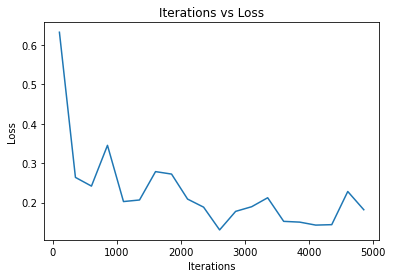

In [12]:
sorted_losses = sorted(model.losses.items(), key=lambda x: x[0])
iterations, losses = zip(*sorted_losses)
iterations = iterations[100:]
np_losses = [loss.cpu().numpy() for loss in losses][100:]

iterations = [n for i, n in enumerate(iterations) if i % 250 == 0]
np_losses = [n for i, n in enumerate(np_losses) if i % 250 == 0]

plt.plot(iterations, np_losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

## Iterations Vs Accuracy

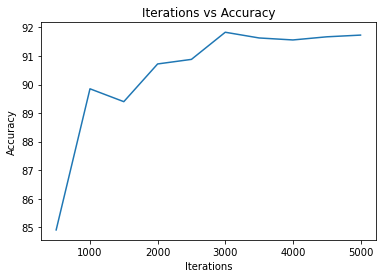

In [13]:
sorted_accuracys = sorted(model.accuracys.items(), key=lambda x: x[0])
iterations, accuracys = zip(*sorted_accuracys)
np_accuracys = [a.cpu().numpy() for a in accuracys]
plt.plot(iterations, np_accuracys)

plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

## Confusion Matrix

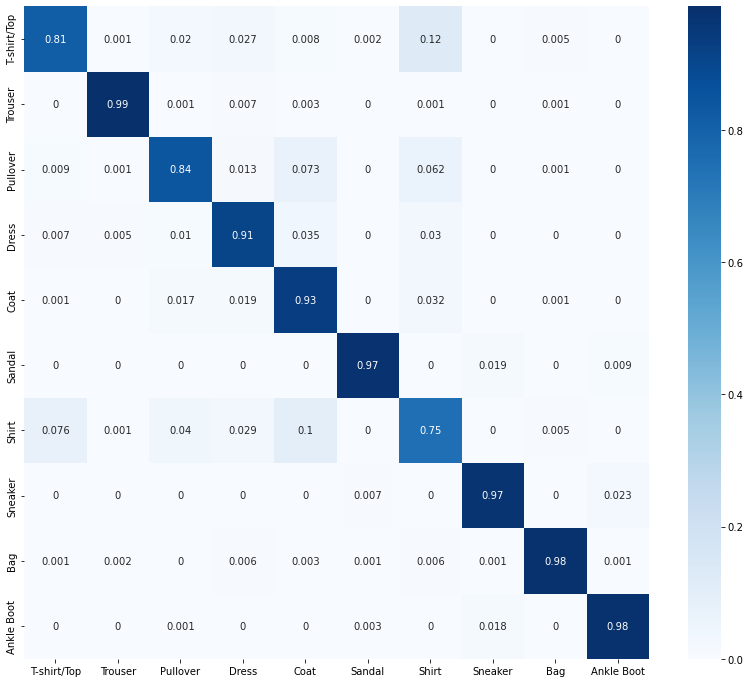

In [14]:
model = torch.load('./data/adam-lr-0001.pth')
y_pred = []
y_true = []

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    x = Variable(images.view(*images.shape))
    outputs = model(x)
    predictions = torch.max(outputs, 1)[1].to(device)

    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predictions.cpu().numpy())

cf_matrix = confusion_matrix(y_true, y_pred)

# Normalize for percentages
cf_matrix_normalized = (cf_matrix / np.sum(cf_matrix)) * 10

# DF for better labeling
df_cf_matrix = pd.DataFrame(
    cf_matrix_normalized, 
    index=[label_map[i] for i in range(10)], 
    columns=[label_map[i] for i in range(10)]
)

plt.figure(figsize=(14, 12))
sns.heatmap(df_cf_matrix, annot=True, cmap=plt.cm.Blues)
plt.show()


# Check how batch_size increases training duration

In [15]:
batch_sizes = [2, 4, 8, 16, 32]
diffs = []

for batch_size in batch_sizes:
    data_dict = load_data(batch_size=batch_size, train_size=50000, val_size=10000)
    temp_train_loader = data_dict['train']
    temp_val_loader =  data_dict['val']
    start = pendulum.now()
    train_and_save(temp_train_loader, temp_val_loader, num_epochs=1)
    diff = pendulum.now() - start
    diffs.append(diff)
    print('-' * 120)
    print(f'A run with batch_size {batch_size} took: {diff.as_interval()}.')
    print('-' * 120)

100%|██████████| 5000/5000 [00:04<00:00, 1047.40it/s]


Epoch[1/1]: Iteration: 25000, Loss: 1.1041532754898071, Accuracy: 86.95999908447266
------------------------------------------------------------------------------------------------------------------------
A run with batch_size 2 took: 1 minute 17 seconds.
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 2500/2500 [00:02<00:00, 1008.86it/s]


Epoch[1/1]: Iteration: 12500, Loss: 0.004779222887009382, Accuracy: 87.22000122070312
------------------------------------------------------------------------------------------------------------------------
A run with batch_size 4 took: 36 seconds.
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 1250/1250 [00:01<00:00, 777.67it/s]


Epoch[1/1]: Iteration: 6250, Loss: 0.07563631981611252, Accuracy: 88.47000122070312
------------------------------------------------------------------------------------------------------------------------
A run with batch_size 8 took: 20 seconds.
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 625/625 [00:01<00:00, 569.55it/s]


Epoch[1/1]: Iteration: 3125, Loss: 0.23996831476688385, Accuracy: 86.75
------------------------------------------------------------------------------------------------------------------------
A run with batch_size 16 took: 12 seconds.
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 313/313 [00:00<00:00, 364.41it/s]

Epoch[1/1]: Iteration: 1563, Loss: 0.3171433210372925, Accuracy: 87.82999420166016
------------------------------------------------------------------------------------------------------------------------
A run with batch_size 32 took: 8 seconds.
------------------------------------------------------------------------------------------------------------------------


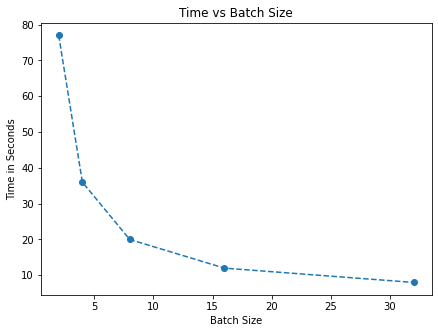

In [16]:
plt.figure(figsize=(7, 5))
plt.title('Time vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Time in Seconds')
plt.plot(batch_sizes, [d.in_seconds() for d in diffs], linestyle='--', marker='o')
plt.show()

We can clearly see that the time taken vs batch_size is not linear.